In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from unet import UNet, FullUNet, MediumUNet, OneLayerUNet, ExtraDeepUNet, SuperDeepUNet, MultiDecoderUNet
import torch.optim as optim
import torch.fft as fft
import torch.nn as nn
from tqdm.notebook import tqdm
#import sigpy as sp
#import sigpy.mri as mr
from skimage.metrics import peak_signal_noise_ratio as compute_psnr
# from models import skip
#from DIP_UNET_models.skip import skip
import glob
import two_channel_dataset_DIP
from torch.nn import init

file1000591.h5_Layer16.npz
[89 19 72 50 91 14 49 38]


In [2]:
for test_direct,test_target,test_smap,test_mask,test_mask_in,no_crop_smap,test_kspace,c_kspace in two_channel_dataset_DIP.test_loader:
    k_np =test_kspace
    A_k_ref = k_np[:,:, 0, :, :] + 1j * k_np[:,:, 1, :, :]
    sense_maps_ref = no_crop_smap[:,:, 0, :, :] + 1j *no_crop_smap[:,:, 1, :, :]
    mask_from_file = test_mask_in[0]
print(A_k_ref.shape)
# neighbor image loading
# #neighbors=[]   
# for direct, target,smap,mask,mask_in,vali_smap, kspace,t_kspace in two_channel_dataset_DIP.train_loader:
#     mask_from_file = mask_in[0]#.detach().numpy()
#     print(mask_from_file.shape)
#     k_np_neigh =kspace.float()
#     sense_map_neighbor = vali_smap[:,:, 0, :, :] + 1j *vali_smap[:,:, 1, :, :]
#     A_k_neighbor = k_np_neigh[:, :,0, :, :] + 1j * k_np_neigh[:, :,1, :, :]
    #neighbors.append(A_k_combine2[0])

torch.Size([1, 15, 640, 368])


In [3]:
def init_decoder_weights(net, init_type='normal', init_gain=0.02):
    def init_func(m):  # define the initialization function
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            if init_type == 'normal':
                init.normal_(m.weight.data, 0.0, init_gain)
            elif init_type == 'xavier':
                init.xavier_normal_(m.weight.data, gain=init_gain)
            elif init_type == 'kaiming':
                init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            elif init_type == 'orthogonal':
                init.orthogonal_(m.weight.data, gain=init_gain)
            else:
                raise NotImplementedError('initialization method [%s] is not implemented' % init_type)
            if hasattr(m, 'bias') and m.bias is not None:
                init.constant_(m.bias.data, 0.0)
        elif classname.find('BatchNorm2d') != -1:
            init.normal_(m.weight.data, 1.0, init_gain)
            init.constant_(m.bias.data, 0.0)

    print('Initialize decoder with %s' % init_type)
    net.decoders.apply(init_func)



In [4]:
def fft_with_shifts(img):
    return fft.fftshift(fft.fft2(fft.ifftshift(img)))

def ifft_with_shifts(ksp):
    return fft.fftshift(fft.ifft2(fft.ifftshift(ksp)))

def ksp_and_mps_to_gt(ksp, mps):
    gt = mps.conj() * ifft_with_shifts(ksp)
    gt = torch.sum(gt, axis=0)
    return gt

def mps_and_gt_to_ksp(mps, gt):
    ksp = fft_with_shifts(mps * gt)
    return ksp

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
net =  MultiDecoderUNet(n_channels=2, n_classes=2, num_decoders=1, bilinear=True).to(device)
# Load the encoder weights
net.encoder.load_state_dict(torch.load('encoder_weights_new.pth'))
init_decoder_weights(net, init_type='normal',init_gain=0.02)
num_epochs = 500
learning_rate = 4e-4
show_every = 50

Initialize decoder with normal


/tmp/ipykernel_1031672/2773891889.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.encoder.load_state_dict(torch.load('encoder_weights_new.pth'))


In [7]:
sum([p.numel() for p in net.parameters()])

4283842

In [8]:
optimizer = optim.Adam(net.parameters(), lr = learning_rate)

In [9]:
criterion = nn.L1Loss()

In [10]:
#new_ref = ksp_and_mps_to_gt(A_k_neighbor[0], sense_map_neighbor[0])

In [11]:
ksp1 = A_k_ref[0]

In [12]:
print(torch.max(torch.abs(ksp1)))

tensor(0.6455)


In [13]:
mps1 = sense_maps_ref[0]

In [14]:
new_ref = ksp_and_mps_to_gt(mask_from_file * ksp1, mps1)

In [15]:
ref = torch.zeros(1,2,640,368)
ref[:,0,:,:] = new_ref.real
ref[:,1,:,:] = new_ref.imag

In [16]:
ref = ref/torch.max(torch.abs(ref))

In [17]:
with torch.no_grad():
    scale_factor = torch.linalg.norm(net(ref.to(device))[0])/torch.linalg.norm(ksp_and_mps_to_gt(ksp1, mps1).to(device))
    target_ksp = scale_factor * ksp1.to(device)
    print('K-space scaled by: ', scale_factor)

K-space scaled by:  tensor(8668.2158, device='cuda:0')


In [18]:
gt1 = ksp_and_mps_to_gt(ksp1, mps1)

In [19]:
print(torch.max(torch.abs( ksp_and_mps_to_gt(target_ksp.cpu(), mps1))))

tensor(0.9905)


In [20]:
gt1 = torch.abs(gt1)/torch.max(torch.abs(gt1))

In [21]:
mask = torch.zeros_like(ksp1)
size = 368
Nsamp = size // 4
center_fraction=0.04
Nsamp_center = int(size * center_fraction)
samples = np.random.choice(size, int(Nsamp - Nsamp_center))
mask[..., samples] = 1
# ACS region
c_from = size // 2 - Nsamp_center // 2
mask[..., c_from:c_from + Nsamp_center] = 1

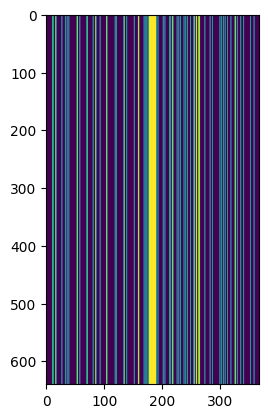

In [22]:
plt.imshow(torch.abs(mask)[0])

In [23]:
aliased = ksp_and_mps_to_gt(mask * ksp1, mps1)

In [24]:
print(torch.max(torch.abs(aliased)))

tensor(6.6111e-05)


In [25]:
aliased = torch.abs(aliased)/torch.max(torch.abs(aliased))

In [26]:
mask_from_file = torch.tensor(mask_from_file, dtype=torch.complex64).to(device)

/tmp/ipykernel_1031672/1494586295.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask_from_file = torch.tensor(mask_from_file, dtype=torch.complex64).to(device)


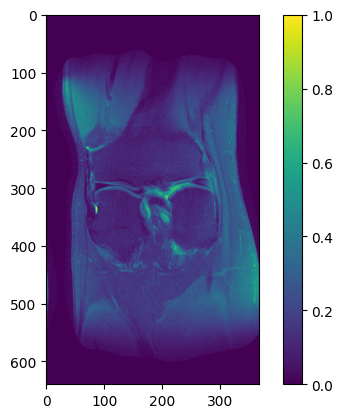

In [27]:
plt.imshow(torch.abs(gt1).numpy())
plt.colorbar()

In [ ]:
prev_new_ref = None
for epoch in tqdm(range(10000)):
    optimizer.zero_grad()
    net_output = net(ref.to(device))[0].squeeze()
    net_output = torch.view_as_complex(net_output.permute(1, 2, 0).contiguous())

    pred_ksp = mps_and_gt_to_ksp(mps1.to(device), net_output)

    new_pred_ksp = (1 - mask_from_file).to(device) * pred_ksp.detach() / scale_factor + mask_from_file * ksp1

    new_ref = ksp_and_mps_to_gt(new_pred_ksp, mps1)
    random_smoothing_temp = torch.zeros_like(new_ref).to(device)

    for jj in range(3):
        random_smoothing = new_ref + 1e-5 * torch.rand((640, 368), dtype=torch.complex64).to(device)
        random_smoothing_temp += random_smoothing

    random_smoothing_final = random_smoothing_temp / 3
    ref[:, 0, :, :] = random_smoothing_final.real
    ref[:, 1, :, :] = random_smoothing_final.imag

    # Continue with your loss computation and optimization steps
    loss = torch.linalg.norm(mask_from_file * target_ksp - mask_from_file * pred_ksp.squeeze()) + 0.001 * torch.linalg.norm(ref.to(device) - net_output)

    # Add the difference to the loss if prev_new_ref is not None
    if prev_new_ref is not None:
        difference = torch.linalg.norm(net_output - prev_new_ref)
        loss += 0.001*difference  # You can also scale this term by a factor if needed

    prev_new_ref = net_output.clone().detach()
    loss.backward()
    optimizer.step()
    with torch.no_grad():
        out = img_map.to(device) * torch.abs(net_output)
        out /= torch.max(out)
        out = out.detach().squeeze()

        losses.append(loss.item())

        out_avg = out_avg * exp_weight + out * (1 - exp_weight)
        avg_psnr = compute_psnr(np.array(torch.abs(gt1))/np.max(np.array(torch.abs(gt1))), np.array(out_avg.cpu())/float(out_avg.max().item()))
        avg_psnrs.append(avg_psnr)

        if epoch%show_every == 0:
            plt.figure(figsize=(12,12))

            plt.subplot(131)
            plt.imshow(out_avg.cpu())
            plt.title('Sliding Average\nPSNR = ' + str(round(avg_psnr, 2)))

            plt.subplot(132)
            plt.imshow(np.abs(gt1.numpy()))
            plt.title('Ground Truth')
            #plt.colorbar()

            plt.show()